# **Import and install libraries**

In [1]:
import numpy as np
import pandas as pd
import os
import copy
import sys
import torch , torchvision
import cv2 as cv
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from tqdm import tqdm
import math
import json
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.utils import draw_bounding_boxes

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
!pip install -U torchvision
!pip install pycocotools
!pip install roboflow
!pip install torchmetrics

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
print(torch.__version__)
print(torchvision.__version__)

2.5.1+cu121
0.20.1+cu121


# **Import dataset from roboflow**

In [6]:
from roboflow import Roboflow
rf = Roboflow(api_key="pyGfhOpHhThaPqbuZUxX")
project = rf.workspace("yihanren").project("skyfusion-z1ayi")
version = project.version(1)
dataset = version.download("coco")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.8 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to SkyFusion-1 in coco:: 100%|██████████| 3000/3000 [00:00<00:00, 3034.99it/s]


# **Delete invalid annotations from all datasets**

In [7]:
def delete_invalid_annotation(path, split):
  with open(os.path.join(path, split, '_annotations.coco.json'), 'r') as f:
    coco_data = json.load(f)

    invalid_annotations = []
    print(f"The number of all annotations in {split}: {len(coco_data['annotations'])}")

    for annotation in coco_data['annotations']:
      bbox = annotation['bbox']
      x, y, width, height = bbox
      image_id = annotation['image_id']

      image_info = next(img for img in coco_data['images'] if img['id'] == image_id)
      image_width, image_height = image_info['width'], image_info['height']

      if x < 0 or y < 0 or x + width > image_width or y + height > image_height:
        invalid_annotations.append(annotation)
        continue

      if width <= 1 or height <= 1:
        invalid_annotations.append(annotation)
        continue

      if width > 0.9 * image_width or height > 0.9 * image_height:
        invalid_annotations.append(annotation)
        continue

      if not (np.isfinite(x) and np.isfinite(y) and np.isfinite(width) and np.isfinite(height)):
        invalid_annotations.append(annotation)
        continue

    print(f"The number of invalid annotations in {split}: {len(invalid_annotations)}")

    coco_data['annotations'] = [
      annotation for annotation in coco_data['annotations']
      if annotation not in invalid_annotations]

    all_images_id = {img['id'] for img in coco_data['images']}
    images_with_annotations = {ann['image_id'] for ann in coco_data['annotations']}
    images_without_annotations = all_images_id - images_with_annotations

    print(f"The number of images without annotations in {split}: {len(images_without_annotations)}")

    with open(os.path.join(path, split, 'cleaned_annotations.coco.json'), 'w') as f:
      json.dump(coco_data, f)

    print(f"Cleaned JSON file saved as 'cleaned_annotations.coco.json' in {os.path.join(path, split)}")

In [8]:
delete_invalid_annotation('/content/SkyFusion-1/' , 'train')
delete_invalid_annotation('/content/SkyFusion-1/' , 'test')
delete_invalid_annotation('/content/SkyFusion-1/' , 'valid')

The number of all annotations in train: 43575
The number of invalid annotations in train: 271
The number of images without annotations in train: 0
Cleaned JSON file saved as 'cleaned_annotations.coco.json' in /content/SkyFusion-1/train
The number of all annotations in test: 11751
The number of invalid annotations in test: 63
The number of images without annotations in test: 0
Cleaned JSON file saved as 'cleaned_annotations.coco.json' in /content/SkyFusion-1/test
The number of all annotations in valid: 8387
The number of invalid annotations in valid: 50
The number of images without annotations in valid: 0
Cleaned JSON file saved as 'cleaned_annotations.coco.json' in /content/SkyFusion-1/valid


# **Data augmentation with albumentations**

In [9]:
def get_transform(train=False):
  if train:
    transform = A.Compose([
      A.Resize(2048,2048),
      A.HorizontalFlip(p=0.4),
      A.VerticalFlip(p=0.4),
      A.RandomBrightnessContrast(brightness_limit=0.1 , constrast_limit=0.1 , p=0.4),
      A.ColorJitter(p=0.1),
      ToTensorV2()] , bbox_params=A.BboxParams(format='coco'))
  else:
    transform = A.Compose([
      A.Resize(2048,2048),
      ToTensorV2()] , bbox_params=A.BboxParams(format='coco'))
  return transform

# **Dataset preparation**

In [10]:
class dataset(torchvision.datasets.VisionDataset):
  def __init__(self , path , split='train' , transforms=None):
    super().__init__(path , transform , target_transform , transforms)
    self.path = path
    self.split = split
    self.coco = COCO(os.path.join(path , split , 'cleaned_annotations.coco.json'))
    self.idx = list(sorted(self.coco.imgs.keys()))
    self.idx = [id for id in self.idx if len(self.load_target(id)) > 0]
    self.transforms = transforms
  def load_image(self , id:int):
    path = self.coco.loadImgs(id)[0]['file_name']
    image = cv.imread(os.path.join(self.path , self.split , path))
    image = cv.cvtColor(image , cv.COLOR_BGR2RGB)
    return image
  def load_target(self, id):
    annotations = self.coco.loadAnns(self.coco.getAnnIds(id))
    return annotations

  def __getitem__(self , index):
    id = self.idx[index]
    image = self.load_image(id)
    target = self.load_target(id)
    target = copy.deepcopy(self.load_target(id))

    boxes = [t['bbox'] + [t['category_id']] for t in target]
    if self.transforms is not None:
      transformed = self.transforms(image=image , bboxes=boxes)
    image = transformed['image']
    boxes = transformed['bboxes']

    new_boxes = []
    for box in boxes:
      xmin = box[0]
      xmax = xmin + box[2]
      ymin = box[1]
      ymax = ymin + box[3]
      new_boxes.append([xmin , ymin , xmax , ymax])

    boxes = torch.tensor(new_boxes , dtype=torch.float32)

    target_dict = {}
    target_dict['boxes'] = boxes
    target_dict['labels'] = torch.tensor([t['category_id'] for t in target] , dtype=torch.int32)
    target_dict['image_id'] = torch.tensor([t['image_id'] for t in target] , dtype=torch.int32)
    target_dict['area'] = (boxes[...,3] - boxes[...,1]) * (boxes[...,2] - boxes[...,0])
    target_dict['iscrowd'] = torch.tensor([t['iscrowd'] for t in target] , dtype=torch.int32)
    return image.div(255) , target_dict

  def __len__(self):
    return len(self.idx)

In [11]:
dataset_path = '/content/SkyFusion-1'

# **Read the cleande json file with COCO**

In [12]:
coco = COCO(os.path.join(dataset_path , 'train' , 'cleaned_annotations.coco.json'))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=0.37s)
creating index...
index created!


{0: {'id': 0, 'name': 'Aircraft-ship-vehicle', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'Aircraft', 'supercategory': 'Aircraft-ship-vehicle'},
 2: {'id': 2, 'name': 'ship', 'supercategory': 'Aircraft-ship-vehicle'},
 3: {'id': 3, 'name': 'vehicle', 'supercategory': 'Aircraft-ship-vehicle'}}

In [13]:
classes = [i[1]['name'] for i in categories.items()]
classes

['Aircraft-ship-vehicle', 'Aircraft', 'ship', 'vehicle']

In [14]:
train_dataset = dataset(path=dataset_path , transforms=get_transform(train=True))
validation_dataset = dataset(path=dataset_path , split='valid' , transforms=get_transform(train=False))

loading annotations into memory...
Done (t=0.37s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


# **Model preparation**

In [15]:
import torchvision
from torchvision.models.detection.rpn import AnchorGenerator

model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(pretrained=True)

anchor_generator = AnchorGenerator(
  sizes=((8,), (16,), (32,), (64,), (128,)),
  aspect_ratios=((0.5, 1.0, 2.0),) * 5)

model.rpn.anchor_generator = anchor_generator

model.rpn.fg_iou_thresh = 0.5
model.rpn.bg_iou_thresh = 0.3
model.rpn.nms_thresh = 0.5
model.rpn.batch_size_per_image = 256
model.rpn.positive_fraction = 0.5

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(
  in_features, n_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth
100%|██████████| 167M/167M [00:01<00:00, 115MB/s]


In [16]:
def collate_fn(batch):
  return tuple(zip(*batch))

# **Preparing data for training the model**

In [17]:
train_loader = torch.utils.data.DataLoader(train_dataset , batch_size=16 , shuffle=True , num_workers=4 , collate_fn=collate_fn)
validation_loader = torch.utils.data.DataLoader(validation_dataset , batch_size=16 , shuffle=False , num_workers=4 , collate_fn=collate_fn)

# **Show some of the images**

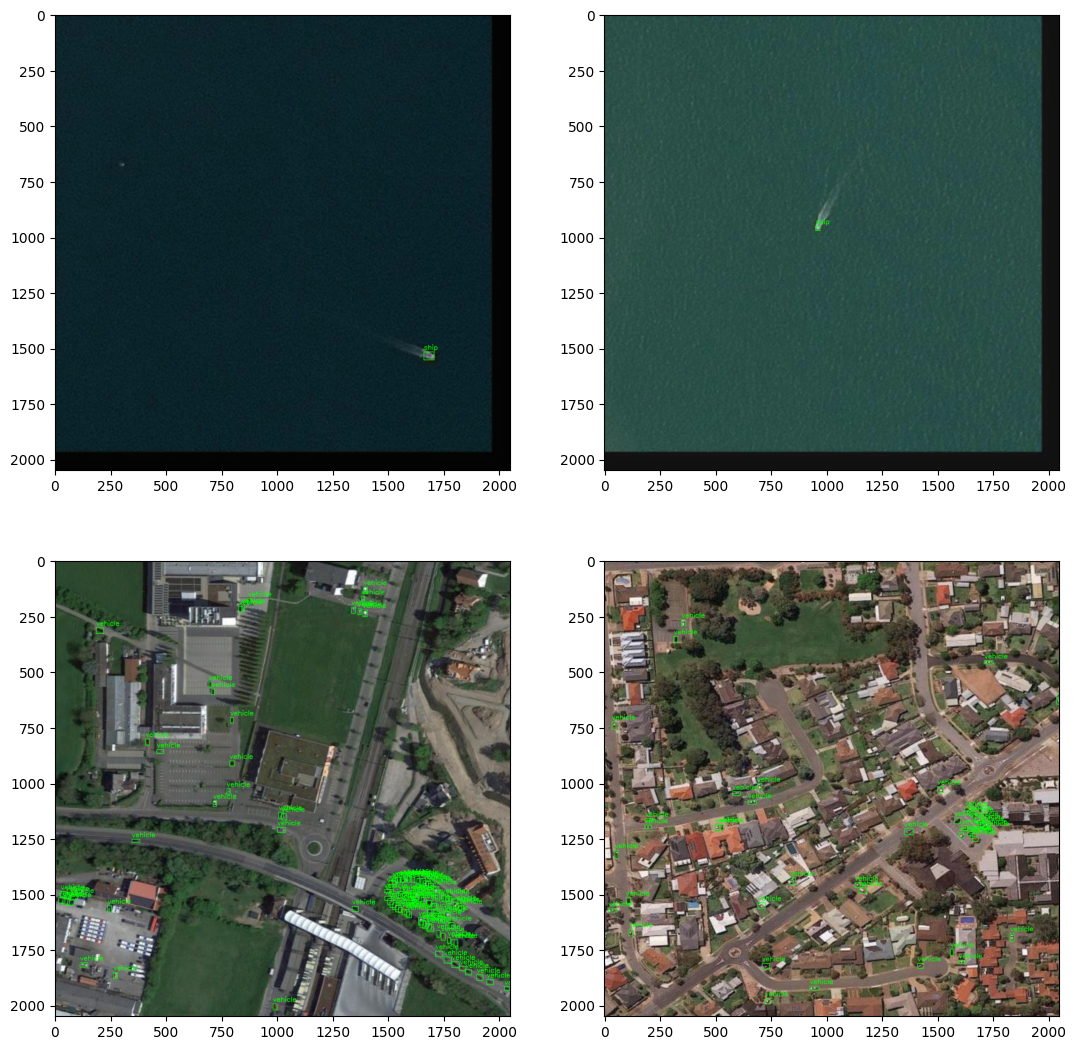

In [18]:
image , target = next(iter(train_loader))
plt.figure(figsize=(13,13))
for n , (img , tar) in enumerate(zip(image , target)):
  plt.subplot(2,2,n+1)

  img = img.permute(1,2,0)
  bboxes = tar['boxes']
  labels = tar['labels']
  img_np = img.numpy().copy()
  img_np = (img_np * 255).astype(np.uint8)

  for i , j in zip(bboxes , labels):
    cv.rectangle(img_np , (int(i[0]) , int(i[1])) , (int(i[2]) , int(i[3])) , (0,255,0) , 2)
    cv.putText(img_np , classes[j] , (int(i[0]) , int(i[1]-10)) , cv.FONT_HERSHEY_SIMPLEX , 1 , (0,255,0) , 2)

  plt.imshow(img_np)
  if n == 3:
    break

# **Change the model device to train with GPU**

In [20]:
device = torch.device('cuda')
model = model.to(device)

In [21]:
if next(model.parameters()).is_cuda:
  print("Model is on CUDA")
else:
  print("Model is on CPU")

Model is on CUDA


# **Specify model optimizer**

In [22]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)

def lr_lambda(epoch):
  if epoch <= 5:
    return 1
  elif epoch <=15:
    return 0.1
  else:
    return 0.01

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer , lr_lambda=lr_lambda)

# **Create checkpoint callback**

In [24]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 23.6 MB/s eta 0:00:00


In [25]:
best_val_map = 0.0
def save_best_model(model, val_map,  best_model_path):
  global best_val_map
  if val_map > best_val_map:
    print(f"New best val_map: {val_map:.4f}, saving model...")
    best_val_map = val_map
    torch.save(model, best_model_path)
  return best_val_map

# **How to train and evaluate the model**

In [26]:
def evaluate_model(model , val_loader , device):
  global best_val_map
  model.eval()
  map_metric_5 = MeanAveragePrecision(iou_thresholds=[0.5])
  map_metric_all = MeanAveragePrecision()
  with torch.no_grad():
    for images ,targets in tqdm(val_loader):
      images = list(image.to(device) for image in images)
      targets = [{k : torch.tensor(v , dtype=torch.int64) for k , v in t.items()} for t in targets]

      outputs = model(images)
      formatted_outputs = [
          {   'boxes' : output['boxes'].detach().cpu(),
              'scores' : output['scores'].detach().cpu(),
              'labels' : output['labels'].detach().cpu()  }
          for output in outputs ]

      formatted_targets = [
          {   'boxes' : target['boxes'].detach().cpu(),
              'labels' : target['labels'].detach().cpu()  }
          for target in targets ]
      map_metric_5.update(formatted_outputs,formatted_targets)
      map_metric_all.update(formatted_outputs,formatted_targets)
  map_result_5 = map_metric_5.compute()
  map_result_all = map_metric_all.compute()
  print('val_map@0.5 : {:.4f} , val_map_all_mean : {:.4f}'.format(map_result_5['map'].item() , map_result_all['map'].item()))
  best_val_map = save_best_model(model , map_result_all['map'].item()  , 'best_model.pth')

In [ ]:
def train_on_epoch(model , train_loader , val_loader , optmizer , device , epoch):
  model.to(device)
  model.train()

  all_losses = []
  all_losses_dict = []

  for images , targets in tqdm(train_loader):
    images = list(image.to(device) for image in images)
    targets = [{k : torch.tensor(v ,dtype=torch.int64).to(device) for k , v in t.items()} for t in targets]
    loss_dict = model(images,targets)
    losses = sum(loss for loss in loss_dict.values())

    loss_dict_append = {k : v.item() for k , v in loss_dict.items()}
    loss_value = losses.item()

    all_losses.append(loss_value)
    all_losses_dict.append(loss_dict_append)


    if not math.isfinite(loss_value):
      print(f"Loss is {loss_value}, stopping trainig")
      print(loss_dict)
      sys.exit(1)

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()

  all_losses_dict = pd.DataFrame(all_losses_dict)
  print('epoch {} , lr {:.6f} , loss {:.6f} , loss_classifier {:.6f} , loss_box {:.6f} , loss_rpn_box {:.6f} , loss_object {:.6f}'.format(
        epoch , optimizer.param_groups[0]['lr'] , np.mean(all_losses) , all_losses_dict['loss_classifier'].mean() ,
        all_losses_dict['loss_box_reg'].mean() , all_losses_dict['loss_rpn_box_reg'].mean() , all_losses_dict['loss_objectness'].mean()))
  evaluate_model(model , val_loader , device)

# **Training the model...**

In [ ]:
n_epochs = 25
for epoch in range(1 , n_epochs + 1):
  train_on_epoch(model , train_loader , validation_loader , optimizer , device , epoch)
  scheduler.step()

100%|██████████| 131/131 [01:50<00:00,  1.18it/s]


epoch 1 , lr 0.010000 , loss 0.314728 , loss_classifier 0.116663 , loss_box 0.075347 , loss_rpn_box 0.035241 , loss_object 0.087476


100%|██████████| 29/29 [00:22<00:00,  1.30it/s]


val_map@0.5 : 0.3777 , val_map_all_mean : 0.1608
New best val_map: 0.1608, saving model...


100%|██████████| 131/131 [01:46<00:00,  1.23it/s]


epoch 2 , lr 0.010000 , loss 0.241426 , loss_classifier 0.084365 , loss_box 0.096031 , loss_rpn_box 0.025306 , loss_object 0.035724


100%|██████████| 29/29 [00:22<00:00,  1.30it/s]


val_map@0.5 : 0.4631 , val_map_all_mean : 0.2174
New best val_map: 0.2174, saving model...


100%|██████████| 131/131 [01:46<00:00,  1.23it/s]


epoch 3 , lr 0.010000 , loss 0.227239 , loss_classifier 0.078519 , loss_box 0.098211 , loss_rpn_box 0.022274 , loss_object 0.028236


100%|██████████| 29/29 [00:22<00:00,  1.30it/s]


val_map@0.5 : 0.5162 , val_map_all_mean : 0.2388
New best val_map: 0.2388, saving model...


100%|██████████| 131/131 [01:47<00:00,  1.22it/s]


epoch 4 , lr 0.010000 , loss 0.215567 , loss_classifier 0.073018 , loss_box 0.098733 , loss_rpn_box 0.020391 , loss_object 0.023424


100%|██████████| 29/29 [00:22<00:00,  1.31it/s]


val_map@0.5 : 0.5341 , val_map_all_mean : 0.2569
New best val_map: 0.2569, saving model...


100%|██████████| 131/131 [01:46<00:00,  1.23it/s]


epoch 5 , lr 0.010000 , loss 0.208985 , loss_classifier 0.069627 , loss_box 0.099441 , loss_rpn_box 0.019206 , loss_object 0.020711


100%|██████████| 29/29 [00:22<00:00,  1.31it/s]


val_map@0.5 : 0.5672 , val_map_all_mean : 0.2729
New best val_map: 0.2729, saving model...


100%|██████████| 131/131 [01:47<00:00,  1.22it/s]


epoch 6 , lr 0.010000 , loss 0.204605 , loss_classifier 0.066851 , loss_box 0.099022 , loss_rpn_box 0.018669 , loss_object 0.020063


100%|██████████| 29/29 [00:22<00:00,  1.29it/s]


val_map@0.5 : 0.5653 , val_map_all_mean : 0.2719


100%|██████████| 131/131 [01:46<00:00,  1.23it/s]


epoch 7 , lr 0.001000 , loss 0.196113 , loss_classifier 0.063183 , loss_box 0.097593 , loss_rpn_box 0.018056 , loss_object 0.017280


100%|██████████| 29/29 [00:22<00:00,  1.31it/s]


val_map@0.5 : 0.5816 , val_map_all_mean : 0.2806
New best val_map: 0.2806, saving model...


100%|██████████| 131/131 [01:46<00:00,  1.22it/s]


epoch 8 , lr 0.001000 , loss 0.193932 , loss_classifier 0.061891 , loss_box 0.097380 , loss_rpn_box 0.017998 , loss_object 0.016663


100%|██████████| 29/29 [00:22<00:00,  1.29it/s]


val_map@0.5 : 0.5836 , val_map_all_mean : 0.2832
New best val_map: 0.2832, saving model...


100%|██████████| 131/131 [01:46<00:00,  1.23it/s]


epoch 9 , lr 0.001000 , loss 0.193166 , loss_classifier 0.061039 , loss_box 0.097455 , loss_rpn_box 0.017773 , loss_object 0.016899


100%|██████████| 29/29 [00:22<00:00,  1.29it/s]


val_map@0.5 : 0.5874 , val_map_all_mean : 0.2842
New best val_map: 0.2842, saving model...


100%|██████████| 131/131 [01:47<00:00,  1.22it/s]


epoch 10 , lr 0.001000 , loss 0.193235 , loss_classifier 0.061500 , loss_box 0.097236 , loss_rpn_box 0.017800 , loss_object 0.016699


100%|██████████| 29/29 [00:22<00:00,  1.31it/s]


val_map@0.5 : 0.5877 , val_map_all_mean : 0.2879
New best val_map: 0.2879, saving model...


100%|██████████| 131/131 [01:46<00:00,  1.23it/s]


epoch 11 , lr 0.001000 , loss 0.192452 , loss_classifier 0.060989 , loss_box 0.097376 , loss_rpn_box 0.017668 , loss_object 0.016418


100%|██████████| 29/29 [00:22<00:00,  1.30it/s]


val_map@0.5 : 0.5901 , val_map_all_mean : 0.2858


100%|██████████| 131/131 [01:46<00:00,  1.23it/s]


epoch 12 , lr 0.001000 , loss 0.193117 , loss_classifier 0.061179 , loss_box 0.097717 , loss_rpn_box 0.017721 , loss_object 0.016501


100%|██████████| 29/29 [00:22<00:00,  1.32it/s]


val_map@0.5 : 0.5913 , val_map_all_mean : 0.2865


100%|██████████| 131/131 [01:46<00:00,  1.22it/s]


epoch 13 , lr 0.001000 , loss 0.190914 , loss_classifier 0.059870 , loss_box 0.097322 , loss_rpn_box 0.017638 , loss_object 0.016084


100%|██████████| 29/29 [00:22<00:00,  1.29it/s]


val_map@0.5 : 0.5940 , val_map_all_mean : 0.2887
New best val_map: 0.2887, saving model...


100%|██████████| 131/131 [01:47<00:00,  1.22it/s]


epoch 14 , lr 0.001000 , loss 0.191390 , loss_classifier 0.060530 , loss_box 0.097395 , loss_rpn_box 0.017490 , loss_object 0.015976


100%|██████████| 29/29 [00:22<00:00,  1.30it/s]


val_map@0.5 : 0.5922 , val_map_all_mean : 0.2882


100%|██████████| 131/131 [01:46<00:00,  1.23it/s]


epoch 15 , lr 0.001000 , loss 0.191357 , loss_classifier 0.059832 , loss_box 0.097506 , loss_rpn_box 0.017610 , loss_object 0.016409


100%|██████████| 29/29 [00:22<00:00,  1.30it/s]


val_map@0.5 : 0.5918 , val_map_all_mean : 0.2876


100%|██████████| 131/131 [01:47<00:00,  1.22it/s]


epoch 16 , lr 0.001000 , loss 0.189700 , loss_classifier 0.059928 , loss_box 0.096858 , loss_rpn_box 0.017420 , loss_object 0.015494


100%|██████████| 29/29 [00:22<00:00,  1.31it/s]


val_map@0.5 : 0.6011 , val_map_all_mean : 0.2911
New best val_map: 0.2911, saving model...


100%|██████████| 131/131 [01:46<00:00,  1.23it/s]


epoch 17 , lr 0.000100 , loss 0.189056 , loss_classifier 0.059136 , loss_box 0.096914 , loss_rpn_box 0.017352 , loss_object 0.015654


100%|██████████| 29/29 [00:22<00:00,  1.30it/s]


val_map@0.5 : 0.5943 , val_map_all_mean : 0.2888


100%|██████████| 131/131 [01:46<00:00,  1.22it/s]


epoch 18 , lr 0.000100 , loss 0.189254 , loss_classifier 0.059030 , loss_box 0.097251 , loss_rpn_box 0.017439 , loss_object 0.015534


100%|██████████| 29/29 [00:22<00:00,  1.31it/s]


val_map@0.5 : 0.5925 , val_map_all_mean : 0.2890


100%|██████████| 131/131 [01:47<00:00,  1.22it/s]


epoch 19 , lr 0.000100 , loss 0.189831 , loss_classifier 0.059320 , loss_box 0.097345 , loss_rpn_box 0.017324 , loss_object 0.015842


100%|██████████| 29/29 [00:22<00:00,  1.31it/s]


val_map@0.5 : 0.5981 , val_map_all_mean : 0.2901


100%|██████████| 131/131 [01:46<00:00,  1.23it/s]


epoch 20 , lr 0.000100 , loss 0.187850 , loss_classifier 0.058254 , loss_box 0.096691 , loss_rpn_box 0.017386 , loss_object 0.015520


100%|██████████| 29/29 [00:22<00:00,  1.27it/s]


val_map@0.5 : 0.6025 , val_map_all_mean : 0.2909


100%|██████████| 131/131 [01:46<00:00,  1.23it/s]


epoch 21 , lr 0.000100 , loss 0.189045 , loss_classifier 0.058907 , loss_box 0.097098 , loss_rpn_box 0.017367 , loss_object 0.015673


100%|██████████| 29/29 [00:22<00:00,  1.31it/s]


val_map@0.5 : 0.5998 , val_map_all_mean : 0.2894


100%|██████████| 131/131 [01:47<00:00,  1.22it/s]


epoch 22 , lr 0.000100 , loss 0.188820 , loss_classifier 0.058843 , loss_box 0.096895 , loss_rpn_box 0.017397 , loss_object 0.015686


100%|██████████| 29/29 [00:22<00:00,  1.30it/s]


val_map@0.5 : 0.5979 , val_map_all_mean : 0.2897


100%|██████████| 131/131 [01:47<00:00,  1.22it/s]


epoch 23 , lr 0.000100 , loss 0.186806 , loss_classifier 0.057737 , loss_box 0.096874 , loss_rpn_box 0.017308 , loss_object 0.014886


100%|██████████| 29/29 [00:22<00:00,  1.31it/s]


val_map@0.5 : 0.5940 , val_map_all_mean : 0.2897


100%|██████████| 131/131 [01:47<00:00,  1.22it/s]


epoch 24 , lr 0.000100 , loss 0.188729 , loss_classifier 0.058820 , loss_box 0.097334 , loss_rpn_box 0.017297 , loss_object 0.015278


100%|██████████| 29/29 [00:22<00:00,  1.30it/s]


val_map@0.5 : 0.6006 , val_map_all_mean : 0.2907


100%|██████████| 131/131 [01:47<00:00,  1.22it/s]


epoch 25 , lr 0.000100 , loss 0.188059 , loss_classifier 0.058639 , loss_box 0.097069 , loss_rpn_box 0.017306 , loss_object 0.015044


100%|██████████| 29/29 [00:22<00:00,  1.31it/s]


val_map@0.5 : 0.6012 , val_map_all_mean : 0.2909


# **Saving the model**

In [ ]:
torch.save(model.state_dict() , 'skymodel_state_dict.pth')
torch.save(model , 'skymodel_complete.pth')

In [ ]:
model.eval()
torch.cuda.empty_cache()

# **Preparing test dataset for testing the model**

In [28]:
test_dataset = dataset(dataset_path , split='test' , transforms=get_transform(train=False))

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


# **Load the best or last model**

In [29]:
model2 = torch.load('/content/skymodel_complete.pth')
model2.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

# **Test and save predict and real annotaions**

In [30]:
!mkdir predict_test_bounding_boxes

In [ ]:
threshold = 0.5 #It depends on the need to draw objects
for z in range(len(test_dataset)):
  image , target = test_dataset[z]
  image_int = torch.tensor(image*255 , dtype=torch.uint8).permute(1,2,0)
  image_np = image_int.numpy().copy()
  with torch.no_grad():
    prediction = model2([image.to(device)])
    pred = prediction[0]
  for i , j , s in zip(pred['boxes'] , pred['labels'] , pred['scores']):
    if s > threshold:
      cv.rectangle(image_np , (int(i[0]) , int(i[1])) , (int(i[2]) , int(i[3])) , (0,255,0) , 2)
      cv.putText(image_np , classes[j] , (int(i[0]) , int(i[1]-10)) , cv.FONT_HERSHEY_SIMPLEX , 1 , (0,255,0) , 2)

  cv.imwrite('/content/predict_test_bounding_boxes/test_{}_image.jpg'.format(z) , cv.cvtColor(image_np , cv.COLOR_BGR2RGB))

In [32]:
!mkdir true_test_bounding_boxes

In [33]:
for z in range(len(test_dataset)):
  image , target = test_dataset[z]
  image = image.permute(1,2,0)
  bboxes = target['boxes']
  labels = target['labels']
  img_np = image.numpy().copy()
  img_np = (img_np * 255).astype(np.uint8)

  for i , j in zip(bboxes , labels):
    cv.rectangle(img_np , (int(i[0]) , int(i[1])) , (int(i[2]) , int(i[3])) , (0,255,0) , 2)
    cv.putText(img_np , classes[j] , (int(i[0]) , int(i[1]-10)) , cv.FONT_HERSHEY_SIMPLEX , 1 , (0,255,0) , 2)
  cv.imwrite('/content/true_test_bounding_boxes/test_{}_image.jpg'.format(z) , cv.cvtColor(img_np , cv.COLOR_BGR2RGB))

In [35]:
import shutil
shutil.make_archive('/content/predict_test_bounding_boxes1' , 'zip' , '/content/predict_test_bounding_boxes')
shutil.make_archive('/content/true_test_bounding_boxes1' , 'zip' , '/content/true_test_bounding_boxes')

'/content/true_test_bounding_boxes1.zip'